In [14]:
!python prepare_data.py

/Users/siddharthv/anaconda3/lib/python3.11/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)
CREATING TRAIN DATASET
Proccessed:  3
Proccessed:  6
Proccessed:  9
Proccessed:  12
Proccessed:  15
Proccessed:  18
Proccessed:  21
Proccessed:  24
Proccessed:  27
Proccessed:  30
Proccessed:  33
Proccessed:  36
Proccessed:  39
Proccessed:  42
Proccessed:  45
Proccessed:  48
Proccessed:  51
Proccessed:  54
Proccessed:  57
Proccessed:  60
Proccessed:  63
Proccessed:  66
Proccessed:  69
Proccessed:  72
Proccessed:  75
Proccessed:  78
Proccessed:  81
Proccessed:  84
Proccessed:  87
Proccessed:  90
Proccessed:  93
Proccessed:  96
Proccessed:  99
Proccessed:  102
Proccessed:  105
Proccessed:  108
Proccessed:  111
Proccessed:  114
Proccessed:  117
Proccessed:  120
Proccessed:  123
Proccessed:  126
Proccessed:  129
Proccessed:  132
Proccessed:  135
Proccessed:  138

In [15]:
!python dataloader.py

In [1]:
from keras.layers import Conv2D
from keras.layers import Activation, Dense, Input, Conv2DTranspose, Dense, Flatten
from keras.layers import ReLU, Dropout, Concatenate, BatchNormalization, Reshape
from keras.layers import LeakyReLU
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from keras.layers import UpSampling2D
import keras.backend as K
import tensorflow as tf

import os
import numpy as np
import PIL
import cv2
import IPython.display
from IPython.display import clear_output
from datetime import datetime
from dataloader import Data, TestData

/Users/siddharthv/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [17]:
# Initialize dataloader
data = Data()
test_data = Data()

In [143]:
# Saves Model in every N minutes
TIME_INTERVALS = 2
SHOW_SUMMARY = True

INPUT_SHAPE = (256, 128, 3)
EPOCHS = 200
BATCH = 1

# 25% i.e 64 width size will be mask from both side
MASK_PERCENTAGE = .50

EPSILON = 1e-9
ALPHA = 0.0004

CHECKPOINT = "Checkpoint directory to save checkpoints during training" #If this directory contains any checkpoint it will be loaded
SAVED_IMAGES = "The images during the training will be saved here"

In [124]:
def dcrm_loss(y_true, y_pred):
    return -tf.reduce_mean(tf.math.log(tf.maximum(y_true, EPSILON)) + tf.math.log(tf.maximum(1. - y_pred, EPSILON)))

d_input_shape = (INPUT_SHAPE[0], int(INPUT_SHAPE[1] * (MASK_PERCENTAGE *2)), INPUT_SHAPE[2])
d_dropout = 0.25
DCRM_OPTIMIZER = Adam(0.0001, 0.5)

In [107]:
def d_build_conv(layer_input, filter_size, kernel_size=4, strides=2, activation='leakyrelu', dropout_rate=d_dropout, norm=True):
    c = Conv2D(filter_size, kernel_size=kernel_size, strides=strides, padding='same')(layer_input)
    if activation == 'leakyrelu':
        c = LeakyReLU(alpha=0.2)(c)
    if dropout_rate:
        c = Dropout(dropout_rate)(c)
    if norm == 'inst':
        c = InstanceNormalization()(c)
    return c


def build_discriminator():
    d_input = Input(shape=d_input_shape)
    d = d_build_conv(d_input, 32, 5,strides=2, norm=False)

    d = d_build_conv(d, 64, 5, strides=2)
    d = d_build_conv(d, 64, 5, strides=2)
    d = d_build_conv(d, 128, 5, strides=2)
    d = d_build_conv(d, 128, 5, strides=2)

    flat = Flatten()(d)
    fc1 = Dense(1024, activation='relu')(flat)
    d_output = Dense(1, activation='sigmoid')(fc1)

    return Model(d_input, d_output)

In [108]:
# Discriminator initialization
DCRM = build_discriminator()
DCRM.compile(loss=dcrm_loss, optimizer=DCRM_OPTIMIZER)
if SHOW_SUMMARY:
    DCRM.summary()

/Users/siddharthv/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 128, 64, 32)    │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 128, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 64, 32, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 64, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 32, 16, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 32, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 16, 8, 128)     │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 16, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 16, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 8, 4, 128)      │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 8, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 8, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     4,195,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,967,169 (18.95 MB)

 Trainable params: 4,967,169 (18.95 MB)

 Non-trainable params: 0 (0.00 B)

In [109]:
#Generator

In [160]:
def gen_loss(y_true, y_pred):
    G_MSE_loss = K.mean(K.square(y_pred - y_true))
    return G_MSE_loss - ALPHA * tf.reduce_mean(tf.math.log(tf.maximum(y_pred, EPSILON)))

g_input_shape = (INPUT_SHAPE[0], int(INPUT_SHAPE[1] * (MASK_PERCENTAGE *2)), INPUT_SHAPE[2])
g_dropout = 0.25
GEN_OPTIMIZER = Adam(0.001, 0.5)
print(g_input_shape)

(256, 128, 3)


In [111]:
from keras.layers import Conv2D, ReLU, BatchNormalization, Input, Conv2DTranspose
from keras.models import Model

def g_build_conv(layer_input, filter_size, kernel_size=4, strides=2, activation='leakyrelu', dropout_rate=g_dropout, norm='batch', dilation=1):
    c = Conv2D(filter_size, kernel_size=kernel_size, strides=strides, padding='same', dilation_rate=dilation)(layer_input)
    if activation == 'leakyrelu':
        c = ReLU()(c)
    if dropout_rate:
        c = Dropout(dropout_rate)(c)
    if norm == 'batch':
        c = BatchNormalization(axis=-1)(c)
    return c



def g_build_deconv(layer_input, filter_size, kernel_size=3, strides=2, activation='relu', dropout=0):
    d = Conv2DTranspose(filter_size, kernel_size=kernel_size, strides=strides, padding='same')(layer_input)
    if activation == 'relu':
        d = ReLU()(d)
    return d


def build_generator():
    g_input = Input(shape=g_input_shape)

    g1 = g_build_conv(g_input, 64, 5, strides=1)
    g2 = g_build_conv(g1, 128, 4, strides=2)
    g3 = g_build_conv(g2, 256, 4, strides=2)

    g4 = g_build_conv(g3, 512, 4, strides=1)
    g5 = g_build_conv(g4, 512, 4, strides=1)

    g6 = g_build_conv(g5, 512, 4, strides=1, dilation=2)
    g7 = g_build_conv(g6, 512, 4, strides=1, dilation=4)
    g8 = g_build_conv(g7, 512, 4, strides=1, dilation=8)
    g9 = g_build_conv(g8, 512, 4, strides=1, dilation=16)

    g10 = g_build_conv(g9, 512, 4, strides=1)
    g11 = g_build_conv(g10, 512, 4, strides=1)

    g12 = g_build_deconv(g11, 256, 4, strides=2)
    g13 = g_build_deconv(g12, 128, 4, strides=2)

    g14 = g_build_conv(g13, 128, 4, strides=1)
    g15 = g_build_conv(g14, 64, 4, strides=1)

    g_output = Conv2D(3, kernel_size=4, strides=(1, 1), activation='tanh', padding='same')(g15)

    return Model(g_input, g_output)


In [112]:
# Generator Initialization
GEN = build_generator()
GEN.compile(loss=gen_loss, optimizer=GEN_OPTIMIZER)
if SHOW_SUMMARY:
    GEN.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 256, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 256, 128, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 256, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 256, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 128, 64, 128)   │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_16 (ReLU)                 │ (None, 128, 64, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128, 64, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128, 64, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 64, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_17 (ReLU)                 │ (None, 64, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 64, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 64, 32, 512)    │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_18 (ReLU)                 │ (None, 64, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 64, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 64, 32, 512)    │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_19 (ReLU)                 │ (None, 64, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 64, 32, 512)    │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 35,159,235 (134.12 MB)

 Trainable params: 35,149,763 (134.09 MB)

 Non-trainable params: 9,472 (37.00 KB)

In [113]:
#Combined model

In [114]:
IMAGE = Input(shape=g_input_shape)
DCRM.trainable = False
GENERATED_IMAGE = GEN(IMAGE)
CONF_GENERATED_IMAGE = DCRM(GENERATED_IMAGE)

COMBINED = Model(IMAGE, [CONF_GENERATED_IMAGE, GENERATED_IMAGE])
COMBINED.compile(loss=['mse', 'mse'], optimizer=GEN_OPTIMIZER)

In [12]:
#Masking and De-Masking

In [13]:


def mask_width_and_rotate(img):
    image = img.copy()
    height = image.shape[0]
    width = image.shape[1]
    new_width = int(width * MASK_PERCENTAGE)
    
    # Rotate the image once
    rotated_image = np.rot90(image)
    
    mask = np.ones([height, new_width, 3])
    missing_x = rotated_image[:, :new_width]
    missing_y = rotated_image[:, width - new_width:]
    missing_part = np.concatenate((missing_x, missing_y), axis=1)
    
    # Update the 'a' array to include the rotated and masked image
    a_image = rotated_image[:, :width - new_width]
    
    return a_image, missing_part

def get_masked_images(images):
    mask_images = []
    missing_images = []
    for image in images:
        mask_image, missing_image = mask_width_and_rotate(image)
        mask_images.append(mask_image)
        missing_images.append(missing_image[:, mask_image.shape[1]:])  # Extract the missing region from 'missing_part'
    return np.array(mask_images), np.array(missing_images)

def get_demask_images(original_images, generated_images):
    demask_images = []
    for o_image, g_image in zip(original_images, generated_images):
        width = g_image.shape[1] // 2
        x_image = g_image[:, :width]    # Taking the left half of the generated image
        y_image = g_image[:, width:]    # Taking the right half of the generated image
        o_image = np.concatenate((o_image, x_image, y_image), axis=1)
        demask_images.append(o_image)
    return np.asarray(demask_images)

In [53]:
x = data.get_data(1)

# Calling the get_masked_images function
a, b = get_masked_images(x)

# After generating the 'c' image from the model
c = get_demask_images(a, b)

In [54]:
print(a.shape)
print(b.shape)
print(c.shape)
print(x.shape)

(1, 256, 128, 3)
(1, 256, 128, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)


After masking
	Original Image			 a 		 b


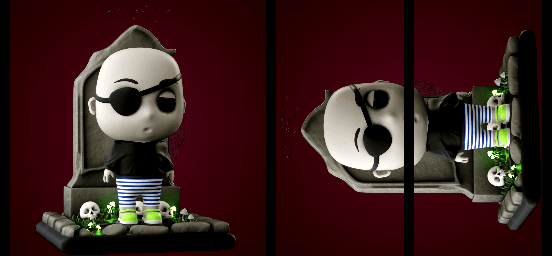

After desmasking: 'b/2' + a + 'b/2' 


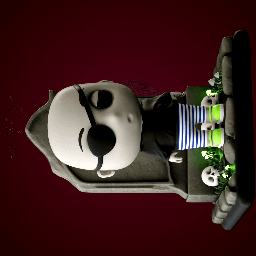

In [55]:
# Masking, Demasking example
# Note: IPython display gives false colors.
x = data.get_data(1)

# a will be the input and b will be the output for the model
a, b = get_masked_images(x)
border = np.ones([x[0].shape[0], 10, 3]).astype(np.uint8)
print('After masking')
print('\tOriginal Image\t\t\t a \t\t b')
image = np.concatenate((border, x[0],border,a[0],border, b[0], border), axis=1)
IPython.display.display(PIL.Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))

print("After desmasking: a + 'b' ")
c = get_demask_images(a,b)
IPython.display.display(PIL.Image.fromarray(cv2.cvtColor(c[0], cv2.COLOR_BGR2RGB)))

In [144]:
def save_model():
    global DCRM, GEN
    models = [DCRM, GEN]
    model_names = ['DCRM','GEN']

    for model, model_name in zip(models, model_names):
        model_path =  CHECKPOINT + "%s.json" % model_name
        weights_path = CHECKPOINT + "/%s.hdf5" % model_name
        options = {"file_arch": model_path, 
                    "file_weight": weights_path}
        json_string = model.to_json()
        open(options['file_arch'], 'w').write(json_string)
        model.save_weights(options['file_weight'])
    print("Saved Model")
    
    
from tensorflow.keras.layers import BatchNormalization
global DCRM, GEN, COMBINED, IMAGE, GENERATED_IMAGE, CONF_GENERATED_IMAGE
def load_model():
    model_names = ['DCRM', 'GEN']
    files = os.listdir(CHECKPOINT)
    print(files)
    for model_name in model_names:
        if model_name + ".json" not in files or model_name + ".hdf5" not in files:
            print("Models not Found")
            return

    # Load DCRM Model
    model_path = CHECKPOINT + "%s.json" % 'DCRM'
    weight_path = CHECKPOINT + "%s.hdf5" % 'DCRM'
    with open(model_path, 'r') as f:
        #DCRM = model_from_json(f.read())
        DCRM.load_weights(weight_path)
    DCRM.compile(loss=dcrm_loss, optimizer=DCRM_OPTIMIZER)

    # Load GEN Model
    model_path = CHECKPOINT + "%s.json" % 'GEN'
    weight_path = CHECKPOINT + "%s.hdf5" % 'GEN'
    with open(model_path, 'r') as f:
        #GEN = model_from_json(f.read())
        GEN.load_weights(weight_path)

    # Combined Model
    DCRM.trainable = False
    IMAGE = Input(shape=g_input_shape)
    GENERATED_IMAGE = GEN(IMAGE)
    CONF_GENERATED_IMAGE = DCRM(GENERATED_IMAGE)

    COMBINED = Model(IMAGE, [CONF_GENERATED_IMAGE, GENERATED_IMAGE])
    COMBINED.compile(loss=['mse', 'mse'], optimizer=GEN_OPTIMIZER)

    print("loaded model")

    
    
def save_image(epoch, steps):
    train_image = test_data.get_data(1)
    if train_image is None:
        train_image = test_data.get_data(1)
        
    test_image = data.get_data(1)
    if test_image is None:
        test_image = test_data.get_data(1)
    
    for nc, original in enumerate([train_image, test_image]):
        if nc:
            print("Predicting with train image")
        else:
            print("Predicting with test image")
            
        mask_image_original , missing_image = get_masked_images(original)
        mask_image = mask_image_original.copy()
        mask_image = mask_image / 127.5 - 1
        missing_image = missing_image / 127.5 - 1
        gen_missing = GEN.predict(mask_image)
        gen_missing = (gen_missing + 1) * 127.5
        gen_missing = gen_missing.astype(np.uint8)
        demask_image = get_demask_images(mask_image_original, gen_missing)

        mask_image = (mask_image + 1) * 127.5
        mask_image = mask_image.astype(np.uint8)

        border = np.ones([original[0].shape[0], 10, 3]).astype(np.uint8)

        file_name = str(epoch) + "_" + str(steps) + ".jpg"
        final_image = np.concatenate((border, original[0],border,mask_image_original[0],border, demask_image[0], border), axis=1)
        if not nc:
            cv2.imwrite(os.path.join(SAVED_IMAGES, file_name), final_image)
        final_image = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)
        print("\t1.Original image \t 2.Input \t\t 3. Output")
        IPython.display.display(PIL.Image.fromarray(final_image))
        print("image saved")


def save_log(log):
    with open('log.txt', 'a') as f:
        f.write("%s\n"%log)

In [145]:
g_input_shape

(256, 128, 3)

In [146]:
print(os.listdir(CHECKPOINT))

['DCRM.hdf5', 'DCRM.json', '.GEN.hdf5.icloud', 'GEN.json']


In [147]:
#train

In [148]:
def train():
    start_time = datetime.now()
    saved_time = start_time
    
    global MIN_D_LOSS, MIN_G_LOSS, CURRENT_D_LOSS, CURRENT_G_LOSS
    for epoch in range(1, EPOCHS):
        steps = 1
        test = None
        while True:
            original = data.get_data(BATCH)
            if original is None:
                break
            batch_size = original.shape[0]

            mask_image, missing_image = get_masked_images(original)
            mask_image = mask_image / 127.5 - 1
            missing_image = missing_image / 127.5 - 1

            # Train Discriminator
            gen_missing = GEN.predict(mask_image)

            real = np.ones([batch_size, 1])
            fake = np.zeros([batch_size, 1])
            
            d_loss_original = DCRM.train_on_batch(missing_image, real)
            d_loss_mask = DCRM.train_on_batch(gen_missing, fake)
            d_loss = 0.5 * np.add(d_loss_original, d_loss_mask)

            # Train Generator
            for i in range(2):
                g_loss = COMBINED.train_on_batch(mask_image, [real, missing_image])
                    
            log = "epoch: %d, steps: %d, DIS loss: %s, GEN loss: %s, Identity loss: %s" \
                                            %(epoch, steps, str(d_loss), str(g_loss[0]), str(g_loss[2]))
            print(log)
            save_log(log)
            steps += 1
            
            # Save model if time taken > TIME_INTERVALS
            current_time = datetime.now()
            difference_time = current_time - saved_time
            if difference_time.seconds >= (TIME_INTERVALS * 60):
                save_model()
                save_image(epoch, steps)
                saved_time = current_time
        clear_output()

In [149]:
GENERATED_IMAGE.shape

(None, 256, 128, 3)

In [155]:
load_model()

['DCRM.hdf5', 'GEN.hdf5', 'DCRM.json', 'GEN.json']
loaded model


1/1 [==============================] - 1s 1s/step
epoch: 4, steps: 1, DIS loss: 10.36163330078125, GEN loss: 1.0208032131195068, Identity loss: 0.020803160965442657
1/1 [==============================] - 1s 1s/step
epoch: 4, steps: 2, DIS loss: 10.36163330078125, GEN loss: 1.017735242843628, Identity loss: 0.017735285684466362
1/1 [==============================] - 1s 1s/step
epoch: 4, steps: 3, DIS loss: 10.36163330078125, GEN loss: 1.02751624584198, Identity loss: 0.027516288682818413
1/1 [==============================] - 1s 1s/step
epoch: 4, steps: 4, DIS loss: 10.36163330078125, GEN loss: 1.0187879800796509, Identity loss: 0.01878799870610237
1/1 [==============================] - 1s 1s/step
epoch: 4, steps: 5, DIS loss: 10.36163330078125, GEN loss: 1.0229767560958862, Identity loss: 0.022976795211434364
1/1 [==============================] - 1s 1s/step
epoch: 4, steps: 6, DIS loss: 10.36163330078125, GEN loss: 1.0145660638809204, Identity loss: 0.014566009864211082
1/1 [=========

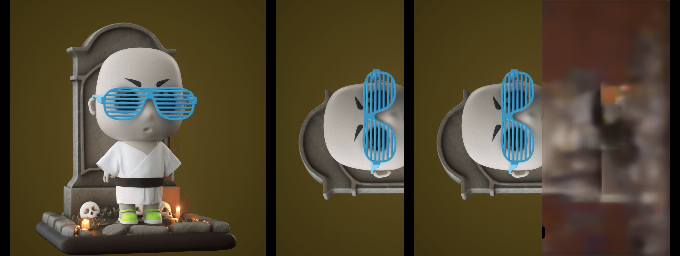

image saved
Predicting with train image
1/1 [==============================] - 1s 1s/step
	1.Original image 	 2.Input 		 3. Output


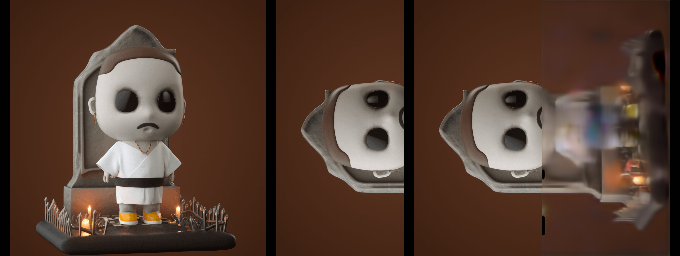

image saved
1/1 [==============================] - 1s 1s/step
epoch: 4, steps: 14, DIS loss: 10.36163330078125, GEN loss: 1.0187255144119263, Identity loss: 0.018725529313087463
1/1 [==============================] - 1s 1s/step
epoch: 4, steps: 15, DIS loss: 10.36163330078125, GEN loss: 1.0355991125106812, Identity loss: 0.03559907525777817
1/1 [==============================] - 1s 1s/step
epoch: 4, steps: 16, DIS loss: 10.36163330078125, GEN loss: 1.0349675416946411, Identity loss: 0.03496751934289932
1/1 [==============================] - 1s 1s/step
epoch: 4, steps: 17, DIS loss: 10.36163330078125, GEN loss: 1.011698842048645, Identity loss: 0.011698877438902855
1/1 [==============================] - 1s 1s/step
epoch: 4, steps: 18, DIS loss: 10.36163330078125, GEN loss: 1.0113126039505005, Identity loss: 0.011312561109662056
1/1 [==============================] - 1s 1s/step
epoch: 4, steps: 19, DIS loss: 10.36163330078125, GEN loss: 1.0099327564239502, Identity loss: 0.00993277132511

KeyboardInterrupt: 

In [38]:
train()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Original image


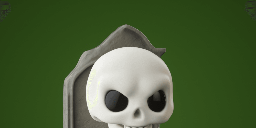

Predicted image


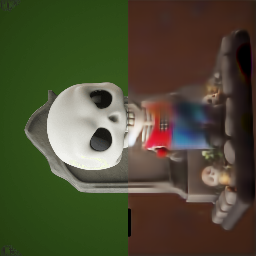

In [161]:
import cv2
import numpy as np
import IPython.display
import PIL.Image

# Load and preprocess the input image
file_name = "PAth to new image for prediction"
image = cv2.imread(file_name)
image = cv2.resize(image, (256, 128))

# Rotate the image left by 90 degrees
rotated_image = np.rot90(image, k=1)

# Normalize the rotated image
input_image = rotated_image / 127.5 - 1
input_image = np.expand_dims(input_image, axis=0)

predicted_image = GEN.predict(input_image)

# Apply post-processing and convert back to original scale
predicted_image = get_demask_images(input_image, predicted_image)[0]
predicted_image = (predicted_image + 1) * 127.5
predicted_image = predicted_image.astype(np.uint8)

# Convert images to RGB format for display
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predicted_image = cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB)

# Display the original and predicted images
print('Original image')
IPython.display.display(PIL.Image.fromarray(image))
print('Predicted image')
IPython.display.display(PIL.Image.fromarray(predicted_image))
